# Height-based results

In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm, to_hex
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from plot_utils import PHASE_TO_NUM_MAP, PHASE_MAP, cblind_cmap, PHASE_LABEL_MAP
from tqdm.notebook import tqdm


def title(label: str) -> str:
    return label.replace("_", " ").title()

def rgb_to_hex(rgb):
    """Function to convert the sns colormap/values to hex for plotly"""
    return to_hex(rgb)

PHASE_NUMS = [1, 2, 3, 4, 5, 6, 7]  # ignore cloudy and unknown pixels for accuracy
PHASES = [PHASE_MAP[i] for i in PHASE_NUMS]

In [6]:
vars = [
    "cnn_20240429_213223",
    "cnn_20240501_090456",
    "rf_1600k_20240514_033147",
    "mlp_1600k_20240514_052837",
    "cloud_phase_mplgr",
]

files = sorted(
    Path("../processing/data/predictions/").glob("nsathermocldphaseC1.c1.2021*.nc")
)
dfs = []
for file in tqdm(files):
    _ds = xr.open_dataset(file)[vars]
    _df = _ds.to_dataframe()
    _df = _df[_df["cloud_phase_mplgr"].isin([1, 2, 3, 4, 5, 6, 7])]
    dfs.append(_df)
    _ds.close()
print("combining dataframes...")
df = pd.concat(dfs)

ds_to_df_columns = {
    "cnn_20240429_213223": "cnnA",
    "cnn_20240501_090456": "cnnB",
    "rf_1600k_20240514_033147": "rf",
    "mlp_1600k_20240514_052837": "mlp",
}
df = df.rename(columns=ds_to_df_columns)
for col in df.columns.tolist():
    df[col] = df[col].map(PHASE_MAP).astype("category")

df

  0%|          | 0/335 [00:00<?, ?it/s]

combining dataframes...


cnnA   cnnB      rf     mlp cloud_phase_mplgr
time                height                                                
2021-01-01 00:57:00 0.16      ice    ice     ice     ice               ice
                    0.19      ice    ice     ice     ice               ice
                    0.22      ice    ice     ice     ice               ice
                    0.25      ice    ice  liquid     ice               ice
2021-01-01 00:57:30 0.16      ice    ice     ice  liquid               ice
...                           ...    ...     ...     ...               ...
2021-12-31 23:59:30 2.38    clear  clear     ice     ice               ice
                    2.41    clear  clear     ice     ice               ice
                    2.44    clear  clear     ice     ice               ice
                    2.47    clear  clear     ice     ice               ice
                    2.50    clear  clear     ice     ice               ice

[65357428 rows x 5 columns]

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from joblib import Parallel, delayed

results = {
    "height": [],
    "model": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "iou": [],
}
models = [
    "cnnA",
    "cnnB",
    "mlp",
    "rf",
]


def compute_metrics(height, df_height, model):
    y_true = df_height["cloud_phase_mplgr"]
    y_pred = df_height[model]
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    iou = jaccard_score(y_true, y_pred, average="macro", zero_division=0)
    return height, model, precision, recall, f1, iou


grouped = df.groupby(level="height")
results_list = Parallel(n_jobs=16)(
    delayed(compute_metrics)(height, df_height, model)
    for height, df_height in tqdm(grouped)
    for model in models
)

for height, model, precision, recall, f1, iou in results_list:
    results["height"].append(height)
    results["model"].append(model)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["f1"].append(f1)
    results["iou"].append(iou)

metrics_df = pd.DataFrame(results)
metrics_df

  0%|          | 0/384 [00:00<?, ?it/s]

,height,model,precision,recall,f1,iou
0,0.16,cnnA,0.811036,0.795360,0.787066,0.533652
1,0.16,cnnB,0.888821,0.886958,0.886553,0.657560
2,0.16,mlp,0.800841,0.694550,0.674910,0.586018
3,0.16,rf,0.812651,0.725329,0.712570,0.618217
4,0.19,cnnA,0.834349,0.824598,0.818503,0.567675
...,...,...,...,...,...,...
1531,11.62,rf,1.000000,1.000000,1.000000,1.000000
1532,11.65,cnnA,1.000000,0.888889,0.941176,0.444444
1533,11.65,cnnB,1.000000,1.000000,1.000000,1.000000
1534,11.65,mlp,1.000000,0.888889,0.941176,0.444444


In [8]:
counts = (
    df.reset_index()  # type: ignore
    .groupby(["height", "cloud_phase_mplgr"])
    .size()
    .reset_index(name="count")
    .rename(columns={"cloud_phase_mplgr": "phase"})
)
counts["percent"] = (
    counts["count"] / counts.groupby("height")["count"].transform("sum") * 100
)
counts

,height,phase,count,percent
0,0.16,drizzle,16693,2.874352
1,0.16,ice,236379,40.701877
2,0.16,liq_driz,7135,1.228569
3,0.16,liquid,112648,19.396753
4,0.16,mixed,122359,21.068881
...,...,...,...,...
2683,11.65,liq_driz,0,0.000000
2684,11.65,liquid,0,0.000000
2685,11.65,mixed,0,0.000000
2686,11.65,rain,0,0.000000


In [9]:
count_pivot = counts.pivot(index="height", columns="phase", values="count")[
    PHASES
].reset_index()
count_pivot

phase,height,liquid,ice,mixed,drizzle,liq_driz,rain,snow
0,0.16,112648,236379,122359,16693,7135,21407,64136
1,0.19,115168,237139,122117,15287,7365,21039,62866
2,0.22,119364,232193,121217,14099,7954,20518,61544
3,0.25,122458,223150,118400,12966,9855,19860,60688
4,0.28,122131,212208,116447,12478,10693,19722,59582
...,...,...,...,...,...,...,...,...
379,11.53,0,61,0,0,0,0,0
380,11.56,0,42,0,0,0,0,0
381,11.59,0,28,0,0,0,0,0
382,11.62,0,12,0,0,0,0,0


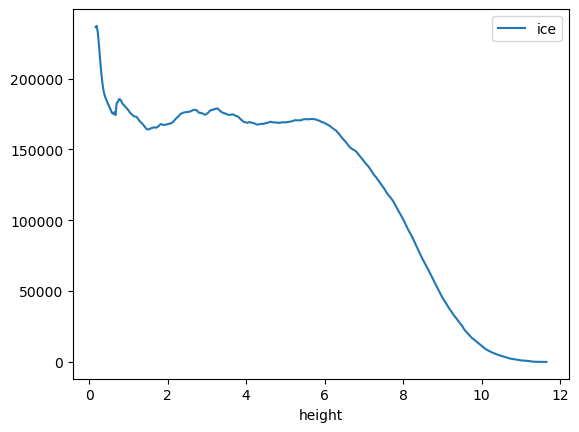

In [ ]:
count_pivot.plot.line(x="height", y="ice")
plt.show()

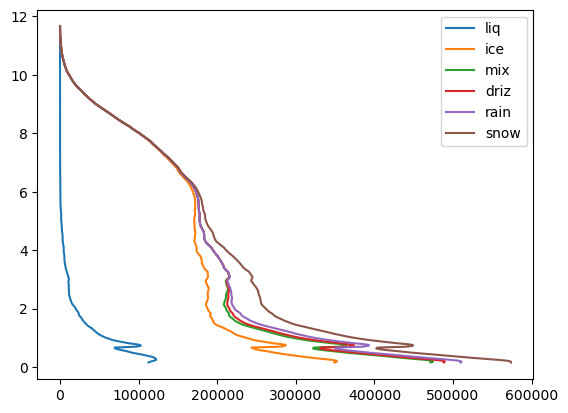

In [ ]:
baseline = np.zeros_like(count_pivot["height"], dtype=np.float64)
baseline += count_pivot["liquid"]
plt.plot(baseline.values, count_pivot["height"], label="liq")
baseline += count_pivot["ice"]
plt.plot(baseline.values, count_pivot["height"], label="ice")
baseline += count_pivot["mixed"]
plt.plot(baseline.values, count_pivot["height"], label="mix")
baseline += count_pivot["drizzle"]
plt.plot(baseline.values, count_pivot["height"], label="driz")
baseline += count_pivot["rain"]
plt.plot(baseline.values, count_pivot["height"], label="rain")
baseline += count_pivot["snow"]
plt.plot(baseline.values, count_pivot["height"], label="snow")

# plt.xlim(0, 100)
# plt.xscale("log")
plt.legend()
plt.show()

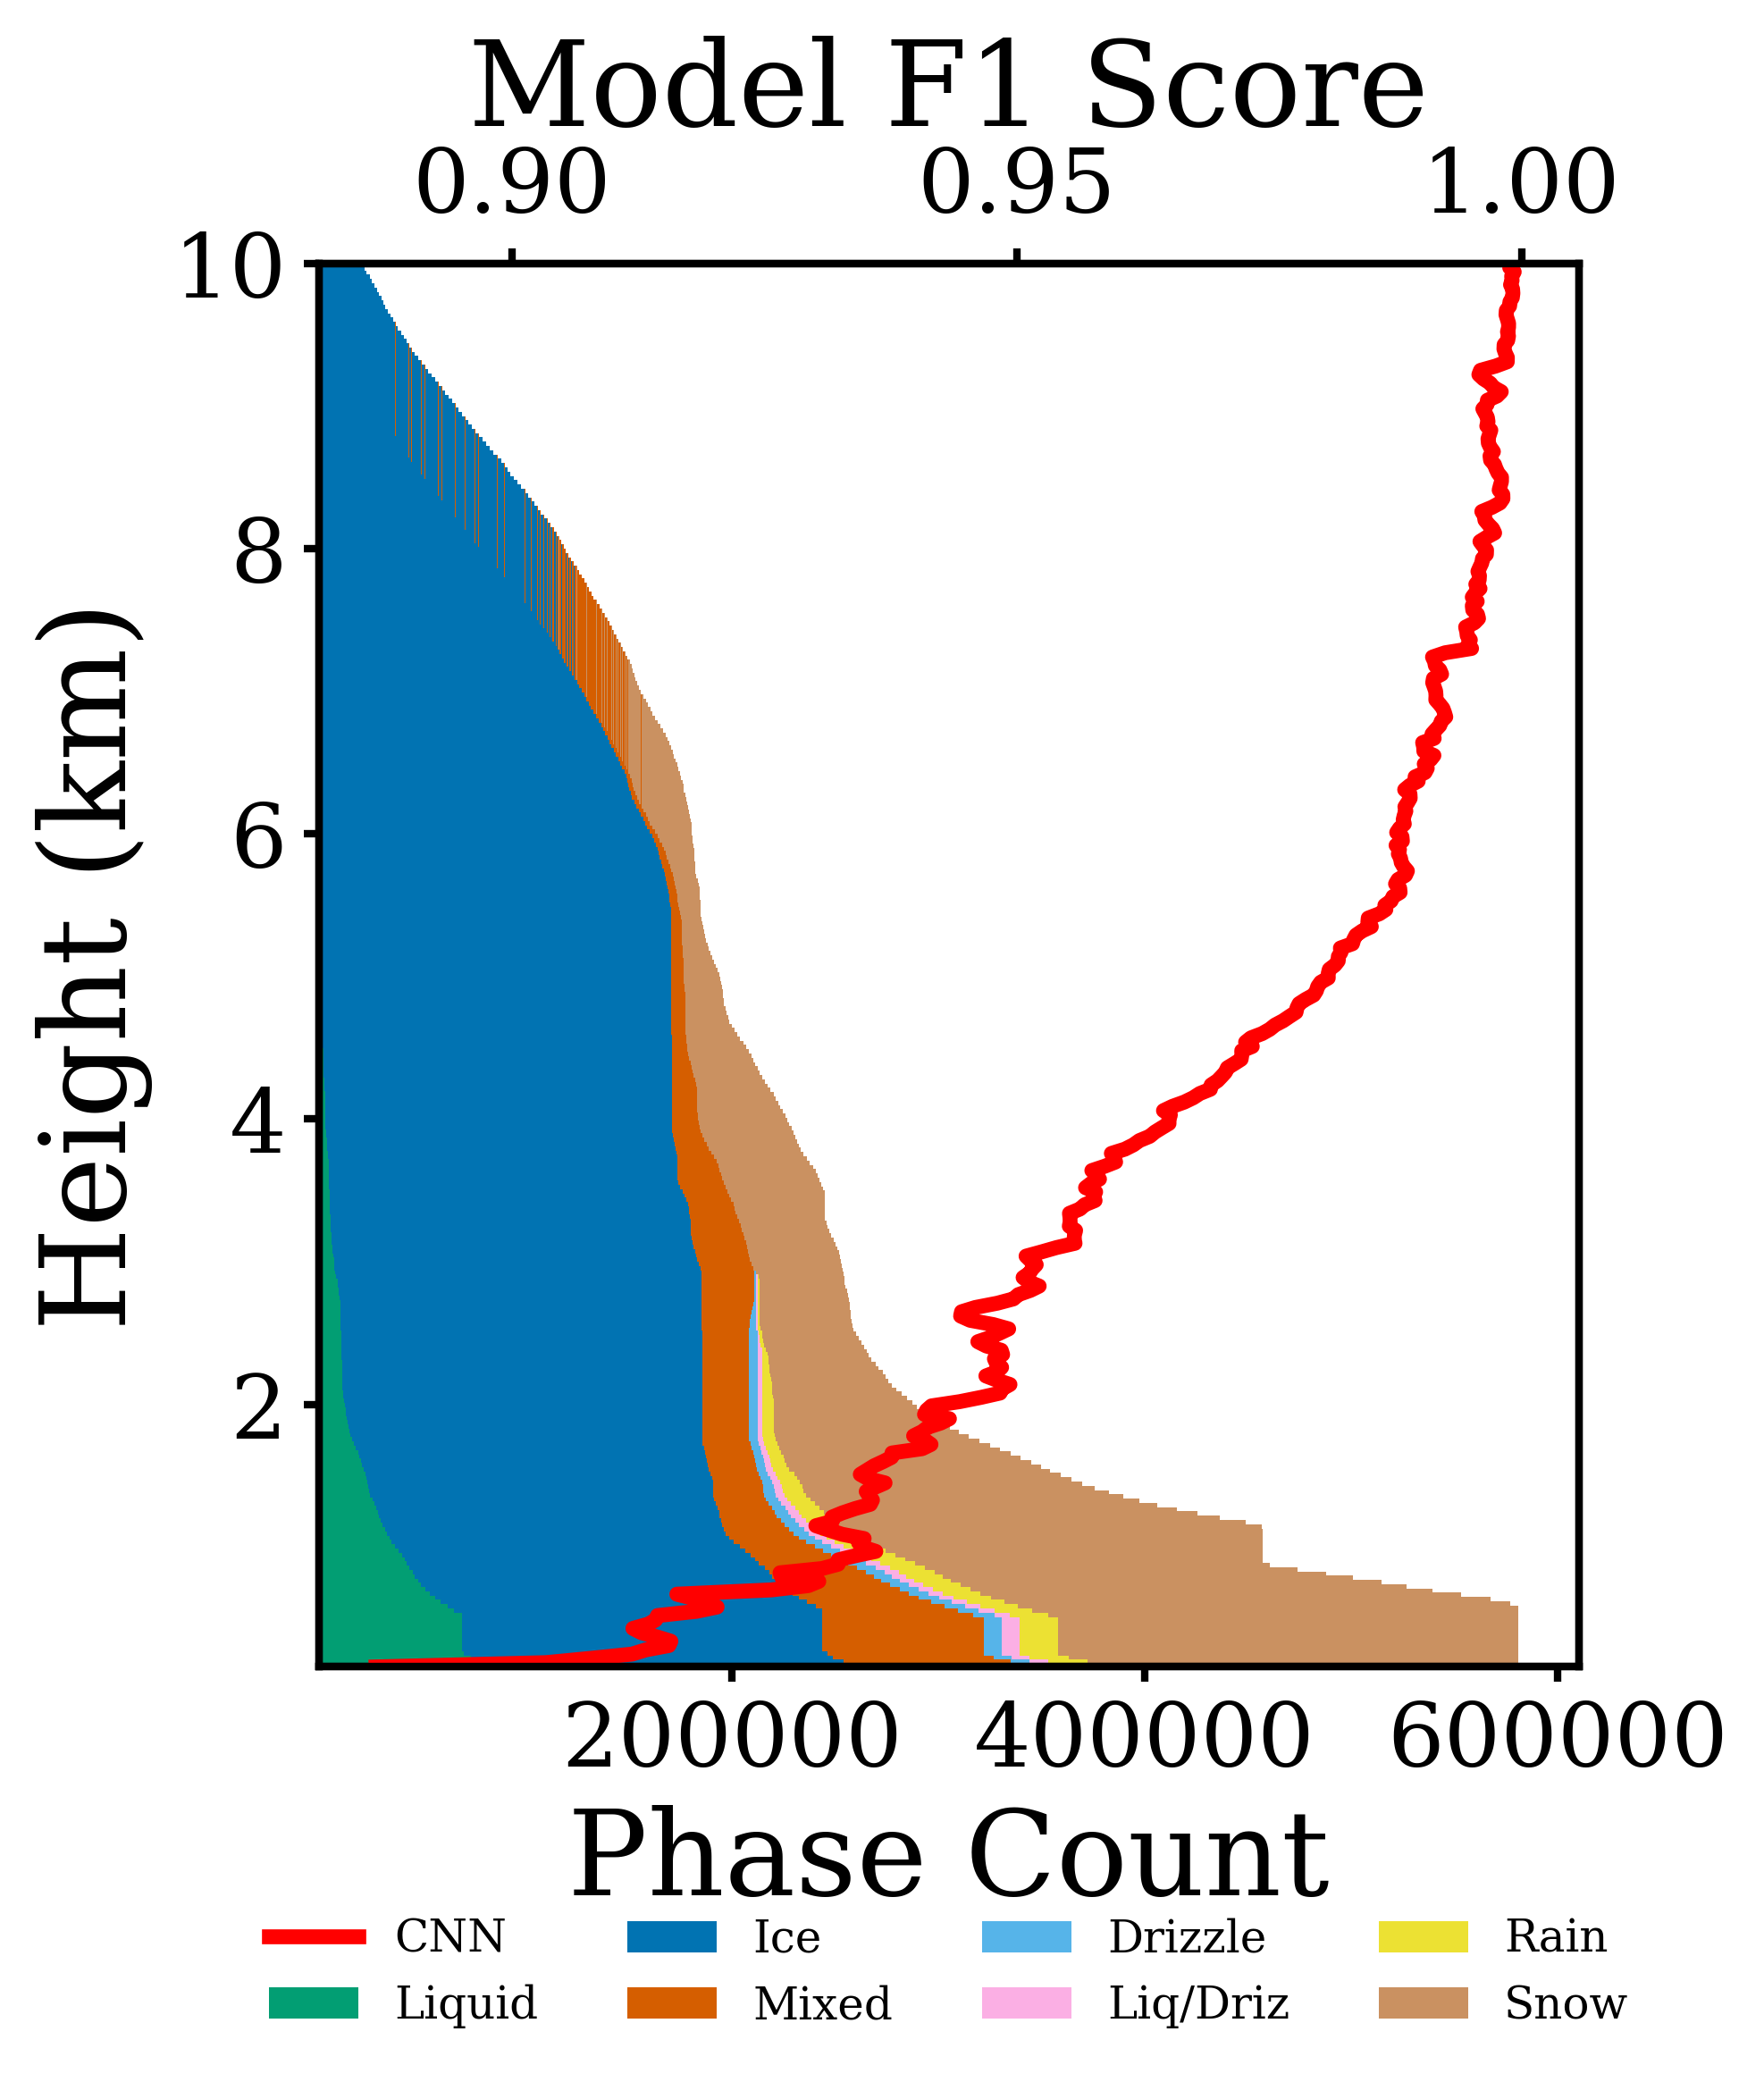

In [ ]:
model_col_to_label = {
    # "cnnA": "CNN (dropout)",
    "cnnB": "CNN",
    # "rf": "RF",
    # "mlp": "MLP",
}
model_cmap = {
    # "rf": "red",
    # "mlp": "orange",
    # "cnnA": "blue",
    "cnnB": "black",
}
metric_to_label = {
    "f1": "F1 Score",
    # "recall": "Recall",
    # "precision": "Precision",
    # "iou": "IOU",
}
with plt.style.context("style.mplstyle"):
    for metric, metric_label in metric_to_label.items():

        fig, ax = plt.subplots(figsize=(5, 6))

        phase_handles = []  # holds barh objects
        baseline = np.zeros_like(count_pivot["height"], dtype=np.float64)
        for phase in PHASES:
            bar = ax.barh(
                count_pivot["height"],
                count_pivot[phase],
                left=baseline,
                color=cblind_cmap[phase],
                label=PHASE_LABEL_MAP[phase],
            )
            baseline += count_pivot[phase]  # type: ignore
            phase_handles.append(bar)

        # ax.set_xlim(0, 100)
        ax.set_ylim(0.16, 10)
        ax.set_ylabel("Height (km)", fontsize=24)
        ax.set_xlabel("Phase Count", fontsize=24)
        ax.tick_params(axis="both", which="major", labelsize=18)

        ax1_2 = ax.twiny()
        model_handles = []
        _models = [
            # "rf",
            # "mlp",
            # "cnnA",
            "cnnB",
        ]
        _colors = [
            "red",
            "orange",
            # "blue",
            "black",
        ]
        for model, color in zip(_models, _colors):
            model_data = metrics_df[metrics_df["model"] == model]
            (line,) = ax1_2.plot(
                model_data[metric],
                model_data["height"],
                label=model_col_to_label[model],
                color=color,
                lw=3,
            )
            model_handles.append(line)
        ax1_2.set_xlabel(f"Model {metric.title()} Score", fontsize=24)
        ax1_2.tick_params(axis="both", which="major", labelsize=18)

        # ax2.stackplot("height", *PHASES, data=count_pivot, colors=[cblind_cmap[p] for p in PHASES])
        # ax1.set_ylim(0.16, 10)

        all_handles = model_handles + phase_handles
        all_labels = [handle.get_label() for handle in all_handles]

        plt.legend(
            handles=all_handles,
            labels=all_labels,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=4,
        )
        plt.tight_layout()
        fig.savefig(f"figures/nsa_{metric}_height_v3.png")
        plt.show()

In [ ]:
# stack[0].set_transform?

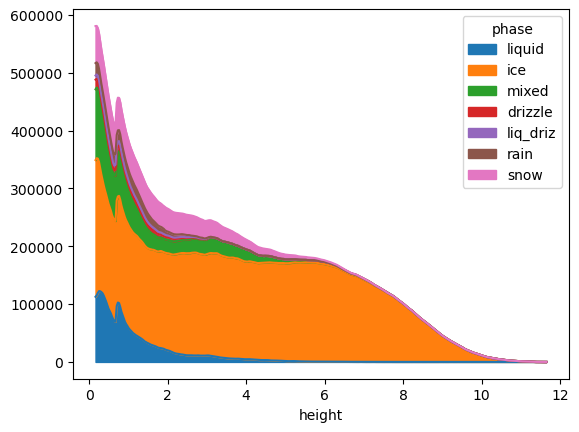

In [ ]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}

count_pivot.set_index("height").plot.area()
# count_pivot.plot.area(y="height", x=list(phases))
plt.show()

In [ ]:
# screw it. matplotlib doesn't want to cooperate on these stack plots. plotly is the way to go.

In [10]:
metrics_df

,height,model,precision,recall,f1,iou
0,0.16,cnnA,0.811036,0.795360,0.787066,0.533652
1,0.16,cnnB,0.888821,0.886958,0.886553,0.657560
2,0.16,mlp,0.800841,0.694550,0.674910,0.586018
3,0.16,rf,0.812651,0.725329,0.712570,0.618217
4,0.19,cnnA,0.834349,0.824598,0.818503,0.567675
...,...,...,...,...,...,...
1531,11.62,rf,1.000000,1.000000,1.000000,1.000000
1532,11.65,cnnA,1.000000,0.888889,0.941176,0.444444
1533,11.65,cnnB,1.000000,1.000000,1.000000,1.000000
1534,11.65,mlp,1.000000,0.888889,0.941176,0.444444


In [11]:
from typing import Any
import plotly.graph_objects as go

def create_figure(
    size: tuple[int, int] = (1200, 800),
    legend_loc: tuple[float, float] = (0.075, 1.0),
    xaxis: dict[str, Any] | None = None,
    xaxis2: dict[str, Any] | None = None,
    yaxis: dict[str, Any] | None = None,
    yaxis2: dict[str, Any] | None = None,
    legend: dict[str, Any] | None = None,
    **kwargs,
):
    """Create a plotly.graph_objects.Figure with some preferred settings.

    Args:
        size (tuple[int, int], optional): Width, height tuple. Defaults to (1200, 800).
        legend_loc (tuple[float, float], optional): Legend location. Defaults to (0.075, 1.0).
        xaxis (dict[str, Any] | None, optional): Optional extra keyword arguments for go.Layout(xaxis=...). Defaults to None.
        xaxis2 (dict[str, Any] | None, optional): Optional extra keyword arguments for go.Layout(xaxis2=...). Defaults to None.
        yaxis (dict[str, Any] | None, optional): Optional extra keyword arguments for go.Layout(yaxis=...). Defaults to None.
        yaxis2 (dict[str, Any] | None, optional): Optional extra keyword arguments for go.Layout(yaxis2=...). Defaults to None.
        legend (dict[str, Any] | None, optional): Optional extra keyword arguments for go.Layout(legend=...). Defaults to None.

    Returns:
        plotly.graph_objects.Figure: The plotly figure with specified + preferred layout settings.
    """
    xaxis = xaxis or {}
    xaxis2 = xaxis2 or {}
    yaxis = yaxis or {}
    yaxis2 = yaxis2 or {}
    legend = legend or {}
    layout_settings = dict(
        width=size[0],
        height=size[1],
        barmode="stack",
        bargap=0,
        bargroupgap=0,
        font=dict(family="serif", size=36, color="black"),
        xaxis={
            **dict(
                showline=True,
                linewidth=2,
                linecolor="black",
                ticks="outside",
                tickwidth=2,
                tickfont_size=22,
                mirror=True,
            ),
            **xaxis,
        },
        xaxis2={
            **dict(
                showline=True,
                linewidth=2,
                linecolor="black",
                ticks="outside",
                tickwidth=2,
                tickfont_size=22,
            ),
            **xaxis2,
        },
        yaxis={
            **dict(
                side="left",
                showgrid=False,
                showline=True,
                linewidth=2,
                linecolor="black",
                ticks="outside",
                tickwidth=2,
                tickfont_size=22,
                mirror=True,
            ),
            **yaxis,
        },
        yaxis2={
            **dict(
                overlaying="y",
                side="right",
                showgrid=False,
                showline=True,
                linewidth=2,
                linecolor="black",
                ticks="outside",
                tickfont_size=22,
                tickwidth=2,
            ),
            **yaxis2,
        },
        plot_bgcolor="white",
        legend={
            **dict(
                x=legend_loc[0],
                y=legend_loc[1],
                bgcolor="rgba(0,0,0,0.1)",
                orientation="h",
                traceorder="normal",
                font_size=28,
            ),
            **legend,
        },
        margin=dict(t=0, b=0, l=0, r=10)
    )
    layout_settings.update(**kwargs)
    fig = go.Figure(layout=go.Layout(**layout_settings))
    return fig

In [20]:
fig = create_figure(
    size=(900, 1200),
    legend_loc=(0.5, -0.13),
    xaxis=dict(title="Model Score", range=[0.0, 1.01], overlaying='x2', side="top"),
    xaxis2=dict(title="Phase Count", side="bottom"),
    yaxis=dict(title="Height (km)", range=[0.15, 10]),
    legend=dict(bgcolor=None, xanchor="center"),
)

# Plot counts
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
count_traces = []
for phase, phase_label in phases.items():
    color = cblind_cmap[phase]
    if isinstance(color, tuple):
        color = rgb_to_hex(color)
    count_traces.append(
        go.Bar(
            x=count_pivot[phase],
            y=count_pivot["height"],
            orientation="h",
            marker_line_width=0,
            marker_color=color,
            name=phase_label,
            opacity=0.8,
            xaxis="x2",
        )
    )
fig.add_traces(count_traces)


# Plot metric lines
metric_traces = []
# model = "cnnB"
models_to_plot = {
    "rf": ("RF", "green"),
    "mlp": ("MLP", "orange"),
    "cnnB": ("CNN", "blue"),
}
metrics_to_plot = {
    "f1": ("F1-Score", "dot"),
    "iou": ("IOU", "solid")
}
for model, (model_label, color) in models_to_plot.items():
    for metric, (metric_label, line_style) in metrics_to_plot.items():
        model_scores = metrics_df[metrics_df["model"] == model]
        metric_traces.append(
            go.Scatter(
                x=model_scores[metric],
                y=model_scores["height"],
                line=dict(
                    color=color,
                    width=4,
                    dash=line_style,
                ),
                name=f"{model_label} {metric_label}",
            )
        )
fig.add_traces(metric_traces)
fig.write_image("figures/height_scores.png", scale=5)
fig.show()